In [1]:
%pip install -q transformers datasets 
%pip install transformers[torch]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset

c:\Users\xavir\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv(r"C:\Users\xavir\Downloads\dataset_sentimientos_500.csv")
df.columns = df.columns.str.strip()
df = df[['Reseña', 'Sentimiento']].dropna()

df['Sentimiento'] = df['Sentimiento'].map({'Positiva': 1, 'Negativa': 0})

if df['Sentimiento'].isna().any():
    raise ValueError("Hay etiquetas no mapeadas (distintas a Positiva/Negativa). Revisa el CSV.")

class_counts = df['Sentimiento'].value_counts()
lengths = df['Reseña'].astype(str).apply(lambda s: len(s.split()))

print("\n## Análisis de variables")
print("Distribución de clases:\n", class_counts)
print("\nLongitud de reseñas (palabras):")
display(lengths.describe())


## Análisis de variables
Distribución de clases:
 Sentimiento
1    250
0    250
Name: count, dtype: int64

Longitud de reseñas (palabras):


count    500.000000
mean       6.020000
std        1.412654
min        4.000000
25%        5.000000
50%        6.000000
75%        7.000000
max       10.000000
Name: Reseña, dtype: float64

In [4]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Reseña'].astype(str).tolist(),
    df['Sentimiento'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['Sentimiento']
)

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_LEN = 128
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=MAX_LEN)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True, max_length=MAX_LEN)

In [6]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [8]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
training_args = TrainingArguments(
    output_dir="results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,

    eval_strategy ="epoch",
    logging_strategy="steps",
    logging_steps=10,

    save_strategy="no",
    report_to="none"
)

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

c:\Users\xavir\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.001500,0.000582,1.000000,1.000000,1.000000,1.000000
2,0.000300,0.000217,1.000000,1.000000,1.000000,1.000000
3,0.000300,0.000189,1.000000,1.000000,1.000000,1.000000


c:\Users\xavir\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
c:\Users\xavir\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TrainOutput(global_step=150, training_loss=0.0688458874464656, metrics={'train_runtime': 39.1067, 'train_samples_per_second': 30.685, 'train_steps_per_second': 3.836, 'total_flos': 11716664184000.0, 'train_loss': 0.0688458874464656, 'epoch': 3.0})

In [11]:
print("\n## Resultados")
results = trainer.evaluate()
display(results)


## Resultados


c:\Users\xavir\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 0.0001893578446470201,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_runtime': 0.4471,
 'eval_samples_per_second': 223.671,
 'eval_steps_per_second': 29.077,
 'epoch': 3.0}

In [12]:
pred_out = trainer.predict(test_dataset)
test_preds = np.argmax(pred_out.predictions, axis=-1)

print("\n### Reporte por clase")
print(classification_report(test_labels, test_preds, target_names=["Negativa(0)", "Positiva(1)"], digits=4))

c:\Users\xavir\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)



### Reporte por clase
              precision    recall  f1-score   support

 Negativa(0)     1.0000    1.0000    1.0000        50
 Positiva(1)     1.0000    1.0000    1.0000        50

    accuracy                         1.0000       100
   macro avg     1.0000    1.0000    1.0000       100
weighted avg     1.0000    1.0000    1.0000       100



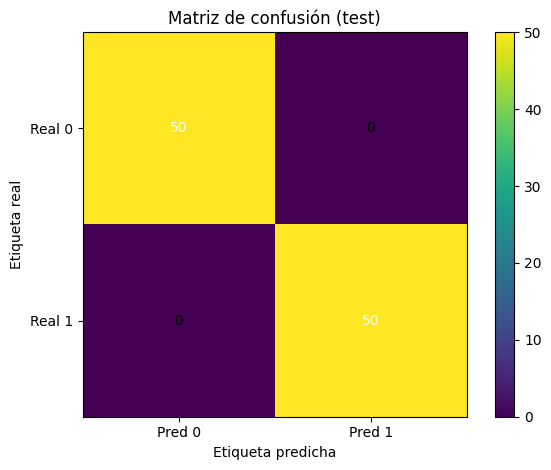

In [13]:
cm = confusion_matrix(test_labels, test_preds, labels=[0, 1])

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión (test)")
plt.colorbar()
plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["Real 0", "Real 1"])

thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("Etiqueta real")
plt.xlabel("Etiqueta predicha")
plt.tight_layout()
plt.show()

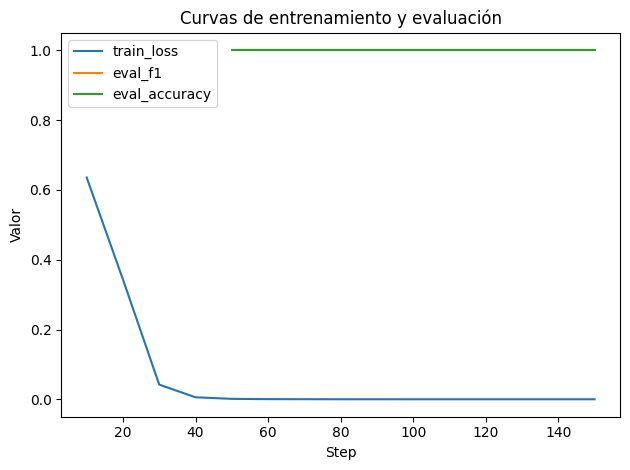

In [14]:
log_history = trainer.state.log_history

steps = []
train_loss = []
eval_steps = []
eval_f1 = []
eval_acc = []

for item in log_history:
    if "loss" in item and "step" in item and "learning_rate" in item:
        steps.append(item["step"])
        train_loss.append(item["loss"])
    if "eval_f1" in item and "eval_accuracy" in item and "step" in item:
        eval_steps.append(item["step"])
        eval_f1.append(item["eval_f1"])
        eval_acc.append(item["eval_accuracy"])

plt.figure()
if len(steps) > 0:
    plt.plot(steps, train_loss, label="train_loss")
if len(eval_steps) > 0:
    plt.plot(eval_steps, eval_f1, label="eval_f1")
    plt.plot(eval_steps, eval_acc, label="eval_accuracy")
plt.title("Curvas de entrenamiento y evaluación")
plt.xlabel("Step")
plt.ylabel("Valor")
plt.legend()
plt.tight_layout()
plt.show()